In [1]:
import os
import re
import glob
from datetime import datetime
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from src.algorithms import SimpleLSTM, MLPClassifier, SVC
from src.datasets import NyseStocksDataset
from src.evaluation import Evaluator, Plotter
from src.utils import print_metrics_as_md
# from src.pipeline import run_pipeline, prepare_data, evaluate_results
# from src.experiments import get_metrics

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
plotter = Plotter('../reports')

time: 194 ms


# Experiments

### Feature selection
- MLP & SimpleLSTM
- All-2C, All-3C, OC-3C, OHLC-3C, Open-3C

Winner: __OC-3C__

|  -   |     All-2C    MLP   |     All-2C    SLSTM_shuffle   |     All-3C    MLP   |     All-3C    SLSTM_shuffle   |     OC-3C    MLP   |     OC-3C    SLSTM_shuffle   |     OHLC-3C    MLP   |     OHLC-3C    SLSTM_shuffle   |     Open-3C    MLP   |     Open-3C    SLSTM_shuffle   |
|:-----|--------------------:|------------------------------:|--------------------:|------------------------------:|-------------------:|-----------------------------:|---------------------:|-------------------------------:|---------------------:|-------------------------------:|
| prec |           0.473675  |                     0.451195  |           0.330751  |                     0.298249  |          0.368896  |                    0.340891  |            0.320769  |                     0.33705    |           0.369802   |                      0.342179  |
| rec  |           0.4825    |                     0.451833  |           0.310833  |                     0.309333  |          0.344833  |                    0.340833  |            0.305     |                     0.336333   |           0.337      |                      0.3395    |
| f1   |           0.435161  |                     0.450036  |           0.308623  |                     0.297981  |          0.300402  |                    0.316042  |            0.287787  |                     0.314503   |           0.234739   |                      0.308558  |
| acc  |           0.4825    |                     0.451833  |           0.310833  |                     0.309333  |          0.344833  |                    0.340833  |            0.305     |                     0.336333   |           0.337      |                      0.3395    |
| mcc  |          -0.0429275 |                    -0.0969692 |          -0.0348393 |                    -0.0367314 |          0.0213947 |                    0.0120531 |           -0.0450657 |                     0.00477629 |           0.00990098 |                      0.0101475 |

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/feature-selection.csv")

### Number of Classes
- MLP & SimpleLSTM & SimpleLSTMShuffle & SVC
- All-2C, All-3C, OC-2C, OC-3C

Winner: __OC-3C__


| -  |   datasets    predictors     |     All-2C    MLP   |     All-2C    SLSTM   |     All-2C    SLSTM_shuffle   |     All-2C    SVC   |     All-3C    MLP   |     All-3C    SLSTM   |     All-3C    SLSTM_shuffle   |     All-3C    SVC   |     OC-2C    MLP   |     OC-2C    SLSTM   |     OC-2C    SLSTM_shuffle   |     OC-2C    SVC   |     OC-3C    MLP   |     OC-3C    SLSTM   |     OC-3C    SLSTM_shuffle   |     OC-3C    SVC   |
|---:|:-----------------------------|--------------------:|----------------------:|------------------------------:|--------------------:|--------------------:|----------------------:|------------------------------:|--------------------:|-------------------:|---------------------:|-----------------------------:|-------------------:|-------------------:|---------------------:|-----------------------------:|-------------------:|
|  0 | prec                         |             0.47367 |               0.25    |                       0.46111 |             0.46438 |             0.33075 |               0.11111 |                       0.30102 |             0.3193  |            0.50449 |              0.25    |                      0.50802 |            0.49017 |            0.3689  |              0.11111 |                      0.34566 |            0.34713 |
|  1 | rec                          |             0.4825  |               0.5     |                       0.466   |             0.46883 |             0.31083 |               0.33333 |                       0.31167 |             0.33267 |            0.502   |              0.5     |                      0.508   |            0.49017 |            0.34483 |              0.33333 |                      0.33467 |            0.34733 |
|  2 | f1                           |             0.43516 |               0.33333 |                       0.44866 |             0.45169 |             0.30862 |               0.16667 |                       0.29172 |             0.31268 |            0.42185 |              0.33333 |                      0.50775 |            0.49017 |            0.3004  |              0.16667 |                      0.28432 |            0.33982 |
|  3 | acc                          |             0.4825  |               0.5     |                       0.466   |             0.46883 |             0.31083 |               0.33333 |                       0.31167 |             0.33267 |            0.502   |              0.5     |                      0.508   |            0.49017 |            0.34483 |              0.33333 |                      0.33467 |            0.34733 |
|  4 | mcc                          |            -0.04293 |               0       |                      -0.07273 |            -0.06664 |            -0.03484 |               0       |                      -0.03433 |            -0.00104 |            0.00599 |              0       |                      0.01602 |           -0.01967 |            0.02139 |              0       |                      0.00225 |            0.02146 |


[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/classes-2vs3.csv")

### Test on Many Sample

- MLP & SimpleLSTMShuffle
- All-3C, OC-3C
- Samples: 600k

Winner: __All-3C, MLP__

When training with more samples it's useful to provide more features.
Still wondering why LSTM isn't better than MLP - might be because LSTM didn't converge (see history plots). The val_acc didn't improve until 20th epoch and afterwards started oszillation intensively (with an increasing mean).

| -  |   datasets    predictors     |     All-3C    MLP   |     All-3C    SLSTM_shuffle   |     OC-3C    MLP   |     OC-3C    SLSTM_shuffle   |
|---:|:-----------------------------|--------------------:|------------------------------:|-------------------:|-----------------------------:|
|  0 | prec                         |             0.39888 |                       0.37705 |            0.36527 |                      0.38532 |
|  1 | rec                          |             0.40535 |                       0.35013 |            0.36832 |                      0.35853 |
|  2 | f1                           |             0.39455 |                       0.29944 |            0.33878 |                      0.30229 |
|  3 | acc                          |             0.40535 |                       0.35013 |            0.36832 |                      0.35853 |
|  4 | mcc                          |             0.10996 |                       0.03225 |            0.05683 |                      0.04865 |

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/600k-samples.csv")

### Why does not Shuffling Fail for LSTM?

- SimpleLSTM & SimpleLSTMShuffle
- OC-3C

Import form shuffling and shuffling-1 (lr=0.1/0.01)

Winner: __?__

### Good batch sizes for MLP and SLSTM

- SimpleLSTM & MLP [3 different batch sizes]
- OC-3C, All-3C

Winner: __?__

In [30]:
datasets = [
    NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv', features=['open', 'close']),
]
[ds.load() for ds in datasets];


time: 10.9 s


In [41]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    return [
        SimpleLSTM('_bs16', n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes,
                   shuffle=True, epochs=50, batch_size=16),
        SimpleLSTM('_bs32', n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes,
                   shuffle=True, epochs=100, batch_size=32),
        SimpleLSTM('_bs64', n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes,
                   shuffle=True, epochs=150, batch_size=64),
        SimpleLSTM('_bs128', n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes,
                   shuffle=True, epochs=200, batch_size=256),
        SimpleLSTM('_bs256', n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes,
                   shuffle=True, epochs=250, batch_size=512),
    ]

evaluator = Evaluator('lstm-batch-size-lr001', datasets, get_predictors, '../reports', seed=42, store=False,
                      n_train_samples=100000, n_test_samples=10000)
metrics = evaluator()
metrics.to_csv("../reports/custom/lstm-batch-size-lr001.csv")

2018-12-08 21:45:40 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-08 21:45:41 [INFO] src.preparation: Train Labels --> -1.0: 20000; 0.0: 20000; 1.0: 20000
2018-12-08 21:45:41 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2010-10-01 00:00:00
2018-12-08 21:45:41 [INFO] src.preparation: Test Labels --> -1.0: 2000; 0.0: 2000; 1.0: 2000
2018-12-08 21:45:41 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-08 21:45:41 [INFO] src.preparation: Done preparing data
2018-12-08 21:45:41 [INFO] src.evaluation.evaluator: ---------- SLSTM_bs16 | OC-3C ----------


ValueError: Error when checking target: expected dense_14 to have shape (3,) but got array with shape (1,)

time: 2.11 s


In [33]:
metrics

datasets         OC-3C                                             
predictors SLSTM_bs128 SLSTM_bs16 SLSTM_bs256 SLSTM_bs32 SLSTM_bs64
prec           0.33154    0.22757     0.33073    0.31991    0.32612
rec            0.32450    0.33667     0.33017    0.32183    0.32033
f1             0.29045    0.22590     0.27636    0.28788    0.27397
acc            0.32450    0.33667     0.33017    0.32183    0.32033
mcc           -0.01456    0.00864    -0.00558   -0.01890   -0.02233

time: 252 ms


2018-12-08 21:41:16 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM-bs16-2018-12-08-214116.png
2018-12-08 21:41:16 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM-bs32-2018-12-08-214116.png
2018-12-08 21:41:17 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM-bs64-2018-12-08-214117.png
2018-12-08 21:41:17 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM-bs128-2018-12-08-214117.png
2018-12-08 21:41:18 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures\history-SLSTM-bs256-2018-12-08-214117.png


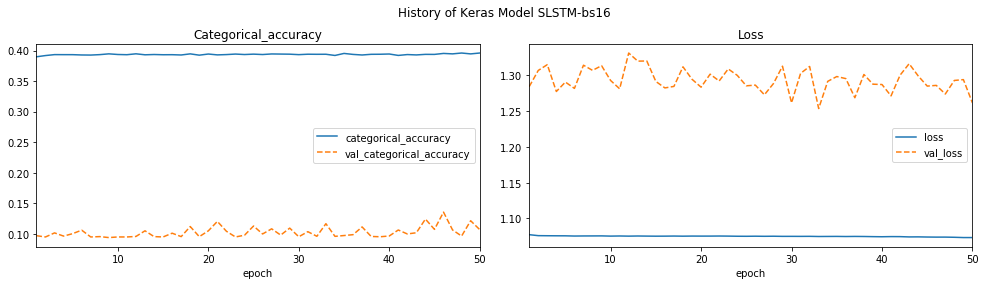

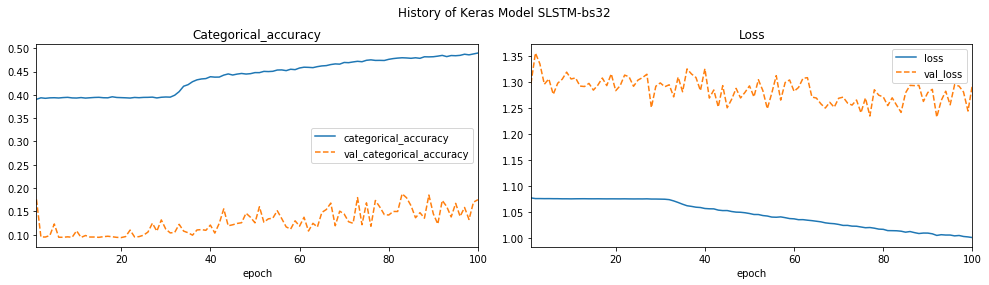

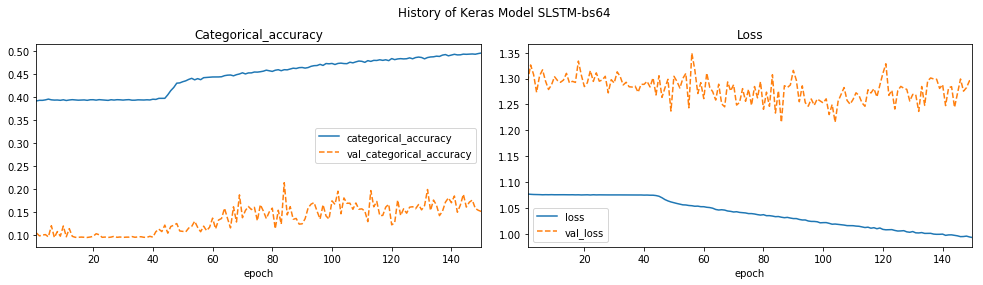

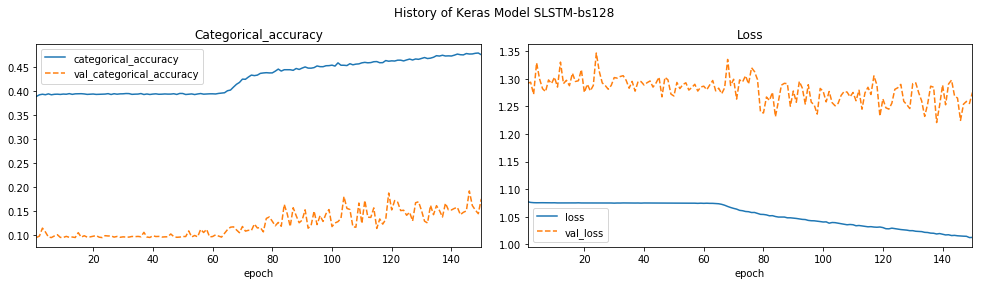

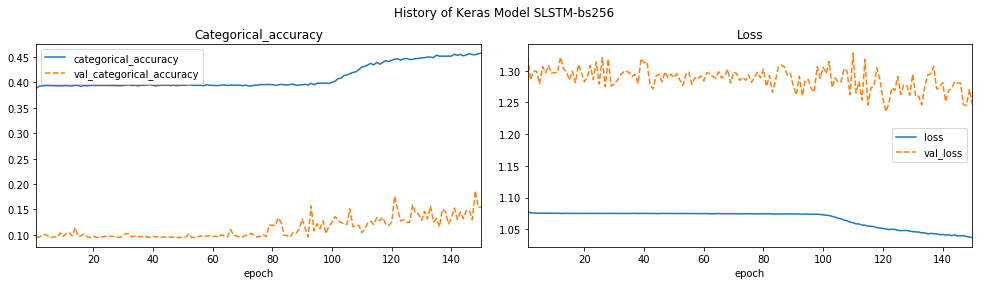

time: 3.61 s


In [40]:
plotter.plot_history(evaluator._temp_pipelines['OC-3C']['SLSTM_bs16'][0].steps[-1][1].history, 'SLSTM-bs16')
plotter.plot_history(evaluator._temp_pipelines['OC-3C']['SLSTM_bs32'][0].steps[-1][1].history, 'SLSTM-bs32')
plotter.plot_history(evaluator._temp_pipelines['OC-3C']['SLSTM_bs64'][0].steps[-1][1].history, 'SLSTM-bs64')
plotter.plot_history(evaluator._temp_pipelines['OC-3C']['SLSTM_bs128'][0].steps[-1][1].history, 'SLSTM-bs128')
plotter.plot_history(evaluator._temp_pipelines['OC-3C']['SLSTM_bs256'][0].steps[-1][1].history, 'SLSTM-bs256')

### Good epsilon for `still` class

- ?
- All-3C[epsilon=0.0001], All-3C[epsilon=0.0005], All-3C[epsilon=0.001], All-3C[epsilon=0.005], All-3C[epsilon=0.01]

Winner: __?__

In [ ]:
# TODO: Store val/loss history of approaches
plotter.plot_history(evaluator._temp_pipelines['OC-3C']['MLP'][0].steps[-1][1].history, store=True)
plotter.plot_history(evaluator._temp_pipelines['OC-3C']['SLSTM_shuffle'][0].steps[-1][1].history, store=True)